In [22]:
# laptop_price_predictor.ipynb

# ===============================
# 1. Import Libraries
# ===============================
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import joblib

In [24]:

# ===============================
# 2. Load Dataset
# ===============================
df = pd.read_csv("../data/laptop.csv")
print("Shape:", df.shape)
display(df.head())

Shape: (1303, 12)


,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [25]:

# ===============================
# 3. EDA
# ===============================
print(df.info())
print(df.describe(include="all").T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   TypeName          1303 non-null   object 
 3   Inches            1303 non-null   float64
 4   ScreenResolution  1303 non-null   object 
 5   Cpu               1303 non-null   object 
 6   Ram               1303 non-null   object 
 7   Memory            1303 non-null   object 
 8   Gpu               1303 non-null   object 
 9   OpSys             1303 non-null   object 
 10  Weight            1303 non-null   object 
 11  Price             1303 non-null   float64
dtypes: float64(2), int64(1), object(9)
memory usage: 122.3+ KB
None
                   count unique                         top  freq  \
Unnamed: 0        1303.0    NaN                         NaN   NaN   
Company             1303    

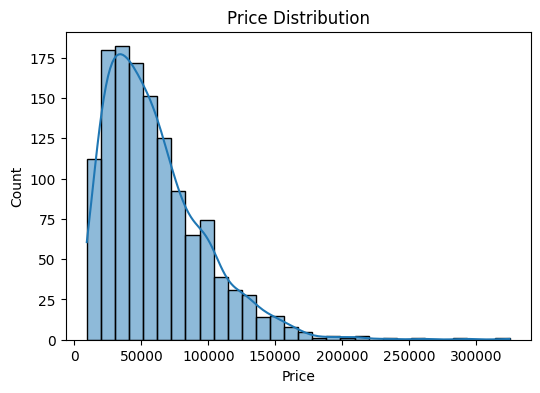

In [26]:

# Price distribution
plt.figure(figsize=(6,4))
sns.histplot(df['Price'], bins=30, kde=True)
plt.title("Price Distribution")
plt.show()


In [27]:

# ===============================
# 4. Feature Engineering
# ===============================

# --- Clean RAM (e.g. "8GB" -> 8)
df['Ram'] = df['Ram'].str.replace("GB","").astype(int)

# --- Extract CPU brand
df['cpu_brand'] = df['Cpu'].apply(
    lambda x: "Intel" if "Intel" in x else ("AMD" if "AMD" in x else "Other")
)

# --- Extract GPU brand
df['gpu_brand'] = df['Gpu'].apply(
    lambda x: "Nvidia" if "NVIDIA" in x.upper() else ("AMD" if "AMD" in x.upper() else "Intel/Other")
)

# --- Touchscreen feature
df['is_touch'] = df['ScreenResolution'].str.contains("Touch", case=False, na=False).astype(int)

# --- IPS feature
df['is_ips'] = df['ScreenResolution'].str.contains("IPS", case=False, na=False).astype(int)

# --- Resolution width & height
df['Resolution_Width'] = df['ScreenResolution'].str.extract(r'(\d+)\s*x')[0].astype(float)
df['Resolution_Height'] = df['ScreenResolution'].str.extract(r'x\s*(\d+)')[0].astype(float)

# --- PPI (pixels per inch)
df['ppi'] = ((df['Resolution_Width']**2 + df['Resolution_Height']**2)**0.5 / df['Inches']).astype(float)

# --- Storage Parsing (HDD / SSD)
def get_hdd(mem):
    if "HDD" in mem:
        num = re.search(r'(\d+)', mem)
        return int(num.group(1)) if num else 0
    return 0

def get_ssd(mem):
    if "SSD" in mem:
        num = re.search(r'(\d+)', mem)
        return int(num.group(1)) if num else 0
    return 0

df['HDD'] = df['Memory'].apply(get_hdd)
df['SSD'] = df['Memory'].apply(get_ssd)
df['total_storage_gb'] = df['HDD'] + df['SSD']

# Final feature set
features = [
    'Company','TypeName','Ram','Inches','ppi','is_touch','is_ips',
    'cpu_brand','gpu_brand','total_storage_gb'
]

X = df[features]
y = df['Price']


In [16]:
# Final feature set
features = [
    'Company','TypeName','Ram','Inches','ppi','is_touch','is_ips',
    'cpu_brand','gpu_brand','total_storage_gb'
]

X = df[features]
y = df['Price']

In [28]:
# ===============================
# 5. Train-Test Split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_cols = ['Company','TypeName','cpu_brand','gpu_brand']
num_cols = ['Ram','Inches','ppi','is_touch','is_ips','total_storage_gb']

# FIXED: sparse_output instead of sparse
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

In [19]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

cat_cols = ['Company', 'TypeName', 'cpu_brand', 'gpu_brand']
num_cols = ['Ram', 'Inches', 'ppi', 'is_touch', 'is_ips', 'total_storage_gb']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)


In [30]:
from math import sqrt

# ===============================
# 6. Models
# ===============================

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, random_state=42, verbosity=0)
}

results = {}

for name, model in models.items():
    pipe = Pipeline([
        ('pre', preprocessor),
        ('model', model)
    ])
    
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = sqrt(mse)   # instead of squared=False
    r2 = r2_score(y_test, preds)
    
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    print(f"\n{name}:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R2:   {r2:.2f}")



LinearRegression:
  MAE:  13714.50
  RMSE: 19844.93
  R2:   0.73

RandomForest:
  MAE:  12107.70
  RMSE: 19222.48
  R2:   0.74

XGBoost:
  MAE:  11990.39
  RMSE: 19521.70
  R2:   0.74


In [31]:
from math import sqrt

# ===============================
# 6. Models
# ===============================

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, random_state=42, verbosity=0)
}

results = {}

for name, model in models.items():
    pipe = Pipeline([
        ('pre', preprocessor),
        ('model', model)
    ])
    
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = sqrt(mse)   # instead of squared=False
    r2 = r2_score(y_test, preds)
    
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    print(f"\n{name}:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R2:   {r2:.2f}")



LinearRegression:
  MAE:  13714.50
  RMSE: 19844.93
  R2:   0.73

RandomForest:
  MAE:  12107.70
  RMSE: 19222.48
  R2:   0.74

XGBoost:
  MAE:  11990.39
  RMSE: 19521.70
  R2:   0.74


In [33]:

# ===============================
# 7. Choose Best Model & Save
# ===============================
best_model_name = max(results, key=lambda x: results[x]["R2"])
print("\nBest Model:", best_model_name, results[best_model_name])

final_pipe = Pipeline([
    ('pre', preprocessor),
    ('model', models[best_model_name])
])
final_pipe.fit(X, y)

joblib.dump(final_pipe, "../models/laptop_price_pipe.pkl")
print("Model saved to models/laptop_price_pipe.pkl")


Best Model: RandomForest {'MAE': 12107.700871106854, 'RMSE': 19222.476313127947, 'R2': 0.7437349716327546}
Model saved to models/laptop_price_pipe.pkl
